# Classifying images of COVID-19, Normal, ViralPneumonia Using InceptionV3

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torchvision.transforms as tt
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.utils.data import random_split

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import copy
from itertools import cycle



In [2]:
print (torch.__version__)
print(torchvision.__version__)

1.9.1
0.10.1


# Set Seaborn style.

In [ ]:
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
data_dir ='./ProcessedGANImages-Dataset'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['test', 'train']
['Covid19', 'Normal', 'ViralPneumonia']


In [4]:
covid19_files = os.listdir(data_dir + "/train/Covid19")
print('No. of training examples for Covid19:', len(covid19_files))
print(covid19_files[:5])

No. of training examples for Covid19: 4000
['Epoch-1521-fake_images4.png', 'Epoch-1522-fake_images1.png', 'Epoch-1522-fake_images4.png', 'Epoch-1522-fake_images5.png', 'Epoch-1523-fake_images0.png']


In [5]:
normal_files = os.listdir(data_dir + "/train/Normal")
print("No. of test examples for Lung Opacity:", len(normal_files))
print(normal_files[:5])

No. of test examples for Lung Opacity: 4000
['Epoch-1023-fake_images4.png', 'Epoch-1023-fake_images5.png', 'Epoch-1024-fake_images0.png', 'Epoch-1024-fake_images1.png', 'Epoch-1024-fake_images2.png']


In [6]:
viral_pneumonia_files = os.listdir(data_dir + "/train/ViralPneumonia")
print("No. of test examples for Viral pneumonia:", len(viral_pneumonia_files))
print(viral_pneumonia_files[:5])

No. of test examples for Viral pneumonia: 4000
['Epoch-1179-fake_images5.png', 'Epoch-1180-fake_images0.png', 'Epoch-1180-fake_images1.png', 'Epoch-1180-fake_images2.png', 'Epoch-1180-fake_images3.png']


# Inputs

In [7]:
feature_extract = True

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Creating training set

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. Source: https://pytorch.org/vision/stable/models.html

In [9]:
img_size = 299
train_dataset = ImageFolder(data_dir+'/train', transform=tt.Compose
                      ([tt.ToTensor(), 
                        #tt.RandomResizedCrop(img_size),
                        tt.RandomHorizontalFlip(), 
                        tt.Resize((299,299)), 
                        #tt.Normalize(mean=(0.5157), std=(0.2546))
                        #tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        tt.Pad(8, padding_mode='reflect'),
                        tt.RandomCrop(img_size),
                        tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                       ]
                      ))

# Exploring data set

In [10]:
len(train_dataset)

12000

In [11]:
train_dataset.classes

['Covid19', 'Normal', 'ViralPneumonia']

In [12]:
# The list of classes is stored in the `.classes` property of the dataset. 
#The numeric label for each element corresponds to index of the element's label in the list of classes.
train_dataset.class_to_idx 

{'Covid19': 0, 'Normal': 1, 'ViralPneumonia': 2}

# Shape and Label of random samples

In [13]:
img, label = train_dataset[0]
print(img.shape, label)

torch.min(img), torch.max(img)

torch.Size([3, 299, 299]) 0


(tensor(-0.9890), tensor(0.9918))

In [14]:
img, label = train_dataset[1200]
print(img.shape, label)

torch.min(img), torch.max(img)

torch.Size([3, 299, 299]) 0


(tensor(-0.9828), tensor(1.))

# View random samples

In [15]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [16]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0), cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Covid19 (0)


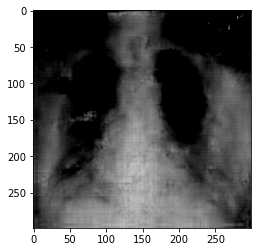

In [17]:
show_example(*train_dataset[671])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Normal (1)


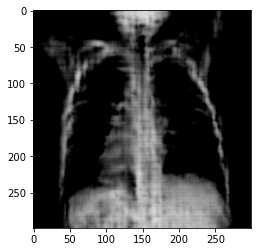

In [18]:
show_example(*train_dataset[5000])

# Get Train and Validation Samples

In [19]:
random_seed = 42
torch.manual_seed(random_seed);

In [20]:
val_size = int(0.2*len(train_dataset))
#print(val_size)
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(9600, 2400)

We can now create data loaders for training and validation, to load the data in batches

In [21]:
batch_size=50

In [22]:
train_dl= DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

We can look at batches of images from the dataset using the make_grid method from torchvision. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

# Normalized Images

In [23]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


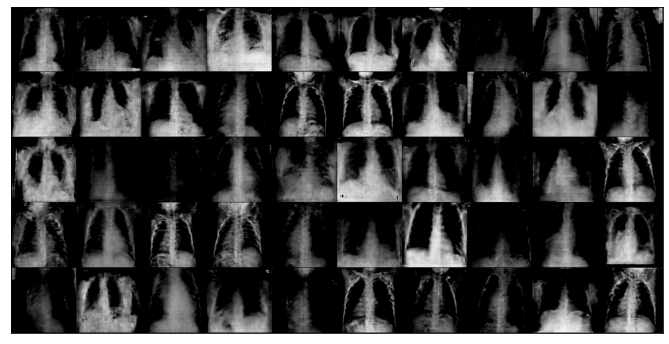

In [24]:
show_batch(train_dl)

# Denormalized Images

In [25]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 1, 1, 1)
    stds = torch.tensor(stds).reshape(1, 1, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        #denorm_images = denormalize(images, 0.5157,0.2546)
        denorm_images = denormalize(images, 0.5,0.5)
        ax.imshow(make_grid(denorm_images[:64], nrow=10).permute(1, 2, 0).clamp(0,1))
        break

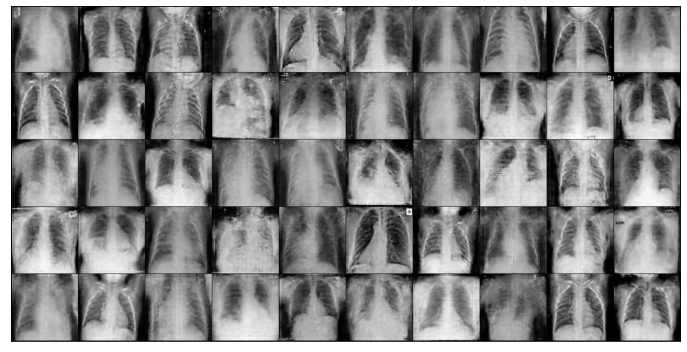

In [26]:
show_batch(train_dl)

# Classes Distribution in dataset

In [ ]:
idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}

def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict

def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(train_dataset), plot_title="Entire Dataset (before train/val/test split)")

In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f},train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        
    def test_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc , 'test_preds':out, 'test_actual_labels':labels}
        
    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() # Combine accuracies 
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}    
        
        


# Use a pretrained model

In [28]:
from torchvision import models

class CovidInceptionV3Model(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.inception_v3(pretrained=True)
        set_parameter_requires_grad(self.network, feature_extract)
        
        # Handle the auxilary net
        num_ftrs = self.network.AuxLogits.fc.in_features
        self.network.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        
        # Handle the primary net
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs,num_classes)

    def forward(self, xb):
        return self.network(xb)

## GPU Utilities and Training Loop

In [29]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [30]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

@torch.no_grad()
def evaluate_test(model, test_loader):
    model.eval()
    outputs = [model.test_step(batch) for batch in test_loader]
    return model.test_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_acc = []
        for batch in tqdm(train_loader):
            loss,acc = model.training_step(batch)
            train_losses.append(loss)
            train_acc.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_acc = []
        lrs = []
        for batch in tqdm(train_loader):
            loss,acc = model.training_step(batch)
            train_losses.append(loss)
            train_acc.append(acc)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [31]:
device = get_default_device()
device

device(type='cuda')

In [32]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

## Finetuning the Pretrained Model via Feature extract method

In [33]:
model = CovidInceptionV3Model(len(train_dataset.classes))
to_device(model, device);

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\Asus/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [34]:
 print(model)

CovidInceptionV3Model(
  (network): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a

In [35]:
summary(model.cuda(), (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [36]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.1192706823349, 'val_acc': 0.3399999439716339}]

In [37]:
epochs = 10
#max_lr = 0.01
#grad_clip = 0.1
#weight_decay = 1e-4
opt_func = torch.optim.Adam
lr=0.0001

In [ ]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(params_to_update, lr=0.001, momentum=0.9)

In [ ]:
%%time
""" history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)"""

In [38]:
%%time
history = fit(epochs, lr, model, train_dl, valid_dl, opt_func=opt_func)

  0%|          | 0/192 [00:00<?, ?it/s]

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not InceptionOutputs

# Saving and Loading the model

In [ ]:
torch.save({
            'epoch': epochs,
            #'model_state_dict': model.state_dict(),
             'best_model_state' : copy.deepcopy(model.state_dict())
            #'optimizer':optimizer.state_dict()
    
              
            }, 'InceptionV3-Covid19.pt') 

In [ ]:
checkpoint = torch.load('InceptionV3-Covid19.pt')
model.load_state_dict(checkpoint['best_model_state']) # Load  model
#optimizer.load_state_dict(checkpoint['optimizer']) # Load optimizer
previous_epochs = checkpoint['epoch']
print("Number of Epochs after training:",previous_epochs)

# Graph of training and validation accuracy 

In [ ]:
def plot_accuracies(history):
    train_accuracies = [x.get('train_acc') for x in history]
    val_accuracies = [x['val_acc'] for x in history]
    plt.plot(train_accuracies, '-bx')
    plt.plot(val_accuracies, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

# Graph of training and validation Loss

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

# Testing with individual images

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=tt.Compose
                      ([tt.ToTensor(), 
                        tt.Grayscale(num_output_channels=3), 
                        tt.Resize((299,299)), 
                        tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                       ]
                      ))

In [ ]:
test_dataset.classes

In [ ]:
test_dataset.classes[1]

In [ ]:
len(test_dataset)

# Total count of each class in test dataset

In [ ]:
import collections

arr=np.array(test_dataset.targets)

def CountFrequency(arr):
    return collections.Counter(arr)  

freq = CountFrequency(arr)


for (key, value) in freq.items():
        print (test_dataset.classes[key],":",key,  " -> ", value)

Let's define a helper function predict_image, which returns the predicted label for a single image tensor.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[150]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[200]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[300]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[170]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

# Testing with batch of images

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)

In [ ]:
result = evaluate_test(model, test_loader)
print(result)

# Build a function to get predictions for all test samples

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).cuda()
    all_test_labels = torch.tensor([]).cuda()
    for batch in loader:
        images, labels = batch
        
        all_test_labels = torch.cat(
            (all_test_labels, labels)
            ,dim=0
        )

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        
    _, all_test_preds = torch.max(all_preds, dim=1)
        
        
    return all_test_preds, all_test_labels, all_preds


In [ ]:
def get_num_correct(test_preds,labels):
  return torch.tensor(torch.sum(test_preds == labels).item())

In [ ]:
with torch.no_grad():
    all_test_preds,all_test_labels, all_preds = get_all_preds(model, test_loader)
print("All Test Predictions:",all_test_preds)
print("All actual test labels:",all_test_labels)

In [ ]:
all_test_preds.shape

In [ ]:
all_test_labels.shape

In [ ]:
all_test_preds.type(torch.int32)

In [ ]:
all_test_labels.type(torch.int32)

In [ ]:
all_test_preds == all_test_labels

In [ ]:
preds_correct = get_num_correct(all_test_preds, all_test_labels)
print('Total correct no of test predictions:', (preds_correct).item())
print('Test Accuracy:', (preds_correct / len(test_dataset)).item() * 100)

# Plotting The Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

In [ ]:
stacked = torch.stack(
(
    all_test_labels.type(torch.int32),all_test_preds.type(torch.int32)
),dim=1

)

In [ ]:
stacked

In [ ]:
stacked[0].tolist()

In [ ]:
cmt = torch.zeros(3,3,dtype=torch.int32)
cmt

In [ ]:
for p in stacked:
    true_label,predicted_label = p.tolist()
    cmt[true_label,predicted_label] = cmt[true_label,predicted_label] + 1
cmt    

In [ ]:
cm = confusion_matrix(all_test_labels.cpu().numpy(),all_test_preds.cpu().numpy())
print(type(cm))
cm

In [ ]:
names = ('COVID-19', 'NORMAL','VIRALPNEUMONIA')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm,names)
plt.xticks(range(3), names, fontsize=16)
plt.yticks(range(3), names, fontsize=16)
plt.show()

# Classification Report

In [ ]:
from sklearn.metrics import classification_report
target_names = ['COVID-19', 'NORMAL', 'VIRALPNEUMONIA']
{'COVID': 0, 'NORMAL': 1, 'VIRALPNEUMONIA': 2}
print(classification_report(all_test_labels.cpu(), all_test_preds.cpu(), target_names=target_names))

# ROC Curve

In [ ]:
# Binarize the output
from sklearn.preprocessing import label_binarize
y_true = label_binarize(all_test_labels.cpu(), classes=[0, 1, 2])
n_classes = y_true.shape[1]

In [ ]:
y_true

In [ ]:
all_preds.cpu().numpy().shape

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_preds.cpu()[:, i],pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), all_preds.cpu().ravel(),pos_label=1)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [ ]:
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

In [ ]:
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [ ]:
# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
labels = cycle(["COVID-19", "NORMAL","VIRAL PNEUMONIA"])
for i, color , label in zip(range(n_classes), colors, labels):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(label, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic to multiclass classification")
plt.legend(loc="lower right")
plt.show()